# AB-test: `recommender_system_test`

## Project goals

### Purpose

* Run A/B-test
* Evaluate its correctness
* Analyze results
* To analyze corectness I'll check:
    * How many users appeared in both groups
    * Test was held during marketing events
    * Potential problems in test duration frames

### Techical task

* Test name: `recommender_system_test` ;
* Groups: А — control, B — new pay funnel;
* Launch date: `2020-12-07`;
* New users attraction stop: `2020-12-21`;
* Test stop date: `2021-01-04`;
* Audience: **15%** of new users from `EU` region;
* Test aim: to test changes following implementation of new advanced recommendation system ;
* Expected number of participants: 6000.
* Expected effect: during 14 days since the registration date users will show conversion boost of 10%+ in each metric:
    * conversion to product page — event name `product_page` ,
    * conversion to product cart — `product_cart` ,
    * purchases — `purchase`

## Data desciption

### `ab_marketing_events.csv`

`ab_marketing_events.csv` — marketing events calendar for 2020

Dataset structure:
* `name` — marketing event name;
* `regions` — regions where marketing event is held;
* `start_dt` — campaign start date;
* `finish_dt` — campaign end date.

### `final_ab_new_users.csv`

`final_ab_new_users.csv` — users registered from 7 to 21 december 2020.

Dataset structure:
* `user_id` — user identificator;
* `first_date` — registration date;
* `region` — user region;
* `device` — user device where registration was made

### `final_ab_events.csv`

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:
* `user_id` — идентификатор пользователя;
* `event_dt` — дата и время покупки;
* `event_name` — тип события;
* `details` — дополнительные данные о событии. Например, для покупок, `purchase`, в этом поле хранится стоимость покупки в долларах.

### `final_ab_participants.csv`

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:
* `user_id` — идентификатор пользователя;
* `ab_test` — название теста;
* `group` — группа пользователя.

## Plan

1. Look through the data:
    * Is data in proper format?
    * How many NaN, duplicates


2. Was the test held correctly. Pay special attention to: 
    * Data is aligned with technical task. Check correctness of all tech task bullets.
    * Test timing. Make sure that it is not influenced by marketing events and other.
    * Test audience. Make sure that there users did not appear in other test and check if users appeared in both A and B groups. Check users spread in groups and in between.


3. Exploratory analysis:
    * How many events per users? How are they distributed in groups?
    * Check events distribution in groups by days 
    * Check conversion dynamics by funnel stages
    * Which findings should be considered before A/B-test conduction?


4. Evaluate A/B-test results
    * What are the results of A/B test?
    * Use Z-test to check it


5. Write conclusions per each stage and the whole test (+add recommendations / questions)

## Data Preprocessing

### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import datetime as dt
import seaborn as sns

from scipy import stats as st
import math as mth

import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

### Read data

In [2]:
try:
    mrkt_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
    new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
    events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
    participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')
    
except:
    mrkt_events = pd.read_csv('datasets/final_ab_marketing_events.csv')
    new_users = pd.read_csv('datasets/final_ab_new_users.csv')
    events = pd.read_csv('datasets/final_ab_events.csv')
    participants = pd.read_csv('datasets/final_ab_participants.csv')

In [3]:
display(mrkt_events.head(), new_users.head(), events.head(), participants.head())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Hi, datasets. let's check your format, NaNs, duplicated

### NaN, duplicates, format

#### `mrkt_events`

Let's check marketing events calendar

In [4]:
display(mrkt_events)
mrkt_events.info()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


14 events in total, no NaNs. Let's check naming correctness in events and regions (that there are no silly mistakes) and change the date column to respective format

**Пропуски**

In [5]:
mrkt_events.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

No NAs

**Mistakes**

Check uniqueness of events and regions (orphographic)

In [6]:
sorted(list(mrkt_events['name'].unique()))

['4th of July Promo',
 'Black Friday Ads Campaign',
 'CIS New Year Gift Lottery',
 'Chinese Moon Festival',
 'Chinese New Year Promo',
 'Christmas&New Year Promo',
 'Dragon Boat Festival Giveaway',
 'Easter Promo',
 "International Women's Day Promo",
 'Labor day (May 1st) Ads Campaign',
 "Single's Day Gift Promo",
 "St. Patric's Day Promo",
 "St. Valentine's Day Giveaway",
 'Victory Day CIS (May 9th) Event']

In [7]:
sorted(list(mrkt_events['regions'].unique()))

['APAC',
 'CIS',
 'EU, CIS, APAC',
 'EU, CIS, APAC, N.America',
 'EU, N.America',
 'N.America']

No mistakes

**Diplicates**

In [8]:
# full duplicates
mrkt_events.duplicated().sum()

0

In [9]:
# partial duplicates
mrkt_events[['name', 'regions']].duplicated().sum()

0

No duplicates

**Date format**

Change event start date `start_dt` and end date `finish_dt` to format: `datetime`

In [10]:
mrkt_events['start_dt'] = pd.to_datetime(mrkt_events['start_dt'])
mrkt_events['finish_dt'] = pd.to_datetime(mrkt_events['finish_dt'])

In [11]:
# check
display(mrkt_events.head(1))
mrkt_events.info()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


**Conclusion**
* No missing values, mistakes or duplicates
* Changed date format to `datetime` 

#### `new_users`

Check new users registered from 7 to 21 Dec 2020

In [12]:
display(new_users.head(1))
new_users.info()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


Should change registration date (`first_date`) format, check that its in proper timeframes (7-21 Dec)

Let's also check duplicates (full and partial) and mistakes in region or device namings

**NaNs**

In [13]:
new_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

Nope

**Mistakes**

Region names (`region`) and devices (`device`)

In [14]:
sorted(list(new_users['region'].unique()))

['APAC', 'CIS', 'EU', 'N.America']

In [15]:
sorted(list(new_users['device'].unique()))

['Android', 'Mac', 'PC', 'iPhone']

None in both regions and devices. Whooho

**Duplicates**

In [16]:
# check only among users
new_users['user_id'].duplicated().sum()

0

In [17]:
# and full duplicates
new_users.duplicated().sum()

0

No duplicates

**Date format**

In [18]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

In [19]:
display(new_users.head(1))
new_users.info()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


Format is fixed. Let's check that test in needed frames

In [20]:
print('min:', new_users['first_date'].min())
print('max:', new_users['first_date'].max())

min: 2020-12-07 00:00:00
max: 2020-12-23 00:00:00


⚠️⚠️⚠️ 

Alert! We expect users only during 7-21 Dec, not 7-23 Dec

Should double check that after merging data to one table that criteria is satisfied 

⚠️⚠️⚠️ 

#### `events`

In [21]:
display(events.head(1))
events.info()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


* Need to check missing values in details and change date format of `event_dt`

**NaNs**

In [22]:
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

NaNs only in `details`

Let's see what values are in `details`

In [23]:
events['details'].unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

Okay, we have cost and NaN. Let's check distribution by events

In [24]:
events.groupby('event_name').agg({'details': 'count'})

,details
event_name,
login,0
product_cart,0
product_page,0
purchase,62740


All data is only in `purchase` event. It means that the column only stores the user purchase amount 

No need to fill it

**Mistakes**

Mistakes check in fields `event_name`, `details`

In [25]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [26]:
events['details'].unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

No mistakes

**Duplicates**

We can make here only full check as other partial checks can be duplicated

In [27]:
events.duplicated().sum()

0

No duplicates

**Format**

Change event date `event_dt` to datetime

In [28]:
events['event_dt'] = pd.to_datetime(events['event_dt'])
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


Format is adjusted, all ok

#### `participants`

In [29]:
display(participants.head())
participants.info()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


* Preliminary everything seems to be in place. Let's make NaN / mistakes / duplicates quick check 

**NaNs**

In [30]:
participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

No missing values

**Mistakes**

In [31]:
participants['group'].unique()

array(['A', 'B'], dtype=object)

Only two groups: A and B. As planned

In [32]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

But we have two tests in `participants` dataset! 

⚠️ Must leave while merging only participants from test `recommender_system_test`

**Duplicates**

In [33]:
# check if there are users being in two groups at the same time
participants[['user_id', 'ab_test']].duplicated().sum()

0

It means that every user appear only in one group

In [34]:
# Now full duplicates check
participants.duplicated().sum()

0

None

### Data merge

Let's merge all the data under variable `df` by the following logic

We have 4 datasets:
* marketing events
* participants
* participants events
* new users

Merge steps:
1. Merge test participants with new users
2. Add participants events
3. Check which marketing events were held during that period

#### `participants` + `new_users`

Add to participants (`participants`) our new users (`new_users`)
   * participants must be only from test `recommender_system_test`

In [35]:
# merge by user_id и left, to save all participants and filter by new users
df = participants[participants['ab_test'] == 'recommender_system_test'].merge(new_users, on='user_id', how='left')

In [36]:
# test columns no longer needed
df = df.drop('ab_test', axis=1)

In [37]:
display(df.head())
df.info()

,user_id,group,first_date,region,device
0,D1ABA3E2887B6A73,A,2020-12-07,EU,PC
1,A7A3664BD6242119,A,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,2020-12-08,EU,Mac
3,04988C5DF189632E,A,2020-12-14,EU,iPhone
4,482F14783456D21B,B,2020-12-14,EU,PC


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6701 entries, 0 to 6700
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     6701 non-null   object        
 1   group       6701 non-null   object        
 2   first_date  6701 non-null   datetime64[ns]
 3   region      6701 non-null   object        
 4   device      6701 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 314.1+ KB


In [38]:
# check that all participants are new users (must be no NaNs)
df.isna().sum()

user_id       0
group         0
first_date    0
region        0
device        0
dtype: int64

Ok, merged correctly 

By techical task all users should be from `EU` region 

Let's filter

In [39]:
df = df[df['region'] == 'EU'].drop('region', axis=1)

In [40]:
display(df.head(1))
df.info()

,user_id,group,first_date,device
0,D1ABA3E2887B6A73,A,2020-12-07,PC


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6351 entries, 0 to 6350
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     6351 non-null   object        
 1   group       6351 non-null   object        
 2   first_date  6351 non-null   datetime64[ns]
 3   device      6351 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 248.1+ KB


6351 users left. Let's check that they match data regisrtation start-stop dates (7-21 Dec)

In [41]:
print('min:', df['first_date'].min())
print('max:', df['first_date'].max())

min: 2020-12-07 00:00:00
max: 2020-12-21 00:00:00


Everybody in its place. Good job, data engineers

Check that users are not under two groups

In [42]:
df.groupby('user_id').agg({'group': 'count'}).query('group > 1')

,group
user_id,


None

Let's check dustribution amount A-B groups

In [43]:
df.groupby('group').agg({'user_id': 'nunique'})

,user_id
group,
A,3634
B,2717


In [44]:
# Fill the initial users to new variable for future track
user_stat = df.groupby('group').agg({'user_id': 'nunique'})

In [45]:
user_stat.loc['A'] / user_stat.sum()

user_id    0.572193
dtype: float64

In [46]:
user_stat.loc['B'] / user_stat.sum()

user_id    0.427807
dtype: float64

In [47]:
user_stat.loc['A'] / user_stat.loc['B']

user_id    1.337505
dtype: float64

Group А higher than В by 33.8%. Shares dustribution 57.2% vs 42.8%

**Вывод:**
* Data has 6351 users from EU what matches technical task criteria of users = 6000
* But distribution is not even 50/50, but 57/43 

#### + `events`

`events` can merge to `df` by `user_id`

In [48]:
df = df.merge(events, on='user_id', how='left')

In [49]:
# check
display(df.head())
df.info()

,user_id,group,first_date,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:27,product_page,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26290 entries, 0 to 26289
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     26290 non-null  object        
 1   group       26290 non-null  object        
 2   first_date  26290 non-null  datetime64[ns]
 3   device      26290 non-null  object        
 4   event_dt    23420 non-null  datetime64[ns]
 5   event_name  23420 non-null  object        
 6   details     3196 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 1.6+ MB


Not all users have events. As we cannot evaluate the effect on funnel metrics without events - we delete these records

In [50]:
df = df.query('event_dt.notna()')

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23420 entries, 0 to 26289
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     23420 non-null  object        
 1   group       23420 non-null  object        
 2   first_date  23420 non-null  datetime64[ns]
 3   device      23420 non-null  object        
 4   event_dt    23420 non-null  datetime64[ns]
 5   event_name  23420 non-null  object        
 6   details     3196 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 1.4+ MB


Let's check new distribution between A and B groups

In [52]:
# add new column to our user stats file with users who have event
user_stat['with_event'] = df.groupby('group').agg({'user_id': 'nunique'})

# adjust name of initial users to `all_users`
user_stat = user_stat.rename(columns={'user_id': 'all_users'})

# calculate abs diff between initial and "with events" users
user_stat['event_diff'] = user_stat['all_users'] - user_stat['with_event']

# calculate % diff 
user_stat['event_diff_%'] = (user_stat['event_diff']/user_stat['all_users'] * 100).round(2)

In [53]:
user_stat

,all_users,with_event,event_diff,event_diff_%
group,,,,
A,3634,2604,1030,28.34
B,2717,877,1840,67.72


* Group A lost 1030 users (-28%)
* Group В lost 1840 users (-68%). That's a lot for a smaller group

Let's check for test event dates match:
* Launch date: `2020-12-07`;
* New users attraction stop: `2020-12-21`;
* Test stop date: `2021-01-04`;

In [54]:
df['event_dt'].agg(['max', 'min'])

max   2020-12-30 12:42:57
min   2020-12-07 00:05:57
Name: event_dt, dtype: datetime64[ns]

Dates are ok but..

⚠️⚠️⚠️ Strange that test stopped by 4 Jan, but the last event was at 30th Dec. It means that for 5 days registration was dead. Should tell to data collection team to check

#### `mrkt_events`

What marketing events were held during our test:
* launch date: `2020-12-07`;
* end date: `2021-01-04`;

Make sure that:
* mkt event start >= new users registration end
* mkt event end <= new users registration start
* region `EU`

In [55]:
start_date = '2020-12-07'
stop_date = '2021-01-04'

In [56]:
mrkt_events.query('start_dt <= @stop_date & finish_dt >= @start_date & regions.str.contains("EU")')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Ok, we have only 1 event "Christmas&New Year Promo"	held from 25 Dec to 3 Jan

Most logical is to add then an indicator `True` / `False` into `df` if this event was during user activity dates or not

In [57]:
promo_start = mrkt_events.query('start_dt <= @stop_date & finish_dt >= @start_date & regions.str.contains("EU")')\
                [['start_dt', 'finish_dt']].iloc[0, 0]

promo_end = mrkt_events.query('start_dt <= @stop_date & finish_dt >= @start_date & regions.str.contains("EU")')\
                [['start_dt', 'finish_dt']].iloc[0, 1]

In [58]:
# short fucntion to indicate that
def in_promo(date):
    if date >= promo_start and date <= promo_end: return True
    else: return False

In [59]:
df['promo'] = df['event_dt'].apply(in_promo)

In [60]:
df.head()

,user_id,group,first_date,device,event_dt,event_name,details,promo
0,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:27,purchase,99.99,False
1,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-25 00:04:56,purchase,4.99,True
2,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:29,product_cart,NaN,False
3,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-25 00:04:57,product_cart,NaN,True
4,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:27,product_page,NaN,False


### Checklist to match the technical task

✅ - checked

⚠️ - not checked

* Test name: `recommender_system_test` ; ✅
* Groups: А — control, B — new pay funnel; ✅
* Launch date: `2020-12-07`; ✅
* New users attraction stop: `2020-12-21`; ✅
* Test stop date: `2021-01-04`; ✅
* Audience: **15%** of new users from `EU` region; ⚠️
* Test aim: to test changes following implementation of new advanced recommendation system ; ✅
* Expected number of participants: 6000. ✅
* Expected effect: during 14 days since the registration date users will show conversion boost of 10%+ in each metric: ⚠️
    * conversion to product page — event name `product_page` ,
    * conversion to product cart — `product_cart` ,
    * purchases — `purchase`

**15% audience from EU**

Calculate how many new users came from EU during 7-21 Dec 2020

In [61]:
EU_users = new_users.query('region == "EU" & first_date >= "2020-12-07" & first_date <= "2020-12-21"')['user_id'].nunique()

EU_users

42340

Divide then by total EU users

In [62]:
user_stat['all_users'].sum() / EU_users

0.15

Perfect match

**14 days since registration**

Let's add the column with difference between registration and event date. Filter by events with no more than 14 days after registration

In [63]:
# column with days difference between registration and event
df['days'] = (df['event_dt'] - df['first_date']).dt.days

In [64]:
df.head()

,user_id,group,first_date,device,event_dt,event_name,details,promo,days
0,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:27,purchase,99.99,False,0
1,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-25 00:04:56,purchase,4.99,True,18
2,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:29,product_cart,NaN,False,0
3,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-25 00:04:57,product_cart,NaN,True,18
4,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:27,product_page,NaN,False,0


In [65]:
# filter dataset by 14 days
df = df.query('days <= 14')

In [66]:
# index refresh
df = df.reset_index(drop=True)

In [67]:
df

,user_id,group,first_date,device,event_dt,event_name,details,promo,days
0,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:27,purchase,99.99,False,0
1,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:29,product_cart,NaN,False,0
2,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:27,product_page,NaN,False,0
3,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:27,login,NaN,False,0
4,A7A3664BD6242119,A,2020-12-20,iPhone,2020-12-20 15:46:06,product_page,NaN,False,0
...,...,...,...,...,...,...,...,...,...
22823,80712ED4EA1B52A5,A,2020-12-14,Android,2020-12-15 20:10:06,product_page,NaN,False,1
22824,80712ED4EA1B52A5,A,2020-12-14,Android,2020-12-20 20:01:34,product_page,NaN,False,6
22825,80712ED4EA1B52A5,A,2020-12-14,Android,2020-12-14 05:48:50,login,NaN,False,0
22826,80712ED4EA1B52A5,A,2020-12-14,Android,2020-12-15 20:10:03,login,NaN,False,1


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22828 entries, 0 to 22827
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     22828 non-null  object        
 1   group       22828 non-null  object        
 2   first_date  22828 non-null  datetime64[ns]
 3   device      22828 non-null  object        
 4   event_dt    22828 non-null  datetime64[ns]
 5   event_name  22828 non-null  object        
 6   details     3123 non-null   float64       
 7   promo       22828 non-null  bool          
 8   days        22828 non-null  int64         
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 1.4+ MB


600 records lost. Let's check in users in variable `user_stat`

In [69]:
user_stat['14_days'] = df.groupby('group').agg({'user_id': 'nunique'})
user_stat

,all_users,with_event,event_diff,event_diff_%,14_days
group,,,,,
A,3634,2604,1030,28.34,2604
B,2717,877,1840,67.72,877


No users lost!

Final distribution betwenn groups A and B is:

In [70]:
print('A group share:', (user_stat.loc['A', '14_days'] / user_stat['14_days'].sum()).round(3))
print('B group share:', (user_stat.loc['B', '14_days'] / user_stat['14_days'].sum()).round(3))

A group share: 0.748
B group share: 0.252


### Conclusion

* In preprocessing read all the files and checked match to the techical task 
* Files are without mistakes and duplicates. Updated formats for dates
* Merged data under single variable `df` and checked to techical task match
* Dustribution between groups A and B is uneven 75 / 25%, but that's okay since the group amount is enough
* ❗Data related concern:
    * test ended by 4 Jan but the last event date was at 30th Dec. Where is rest 5 days data? (transfer this concern to data collection team)

## Exploratory Data Analysis

Now we'll check similarity and difference between groups:

1. Average amount of events per user
2. Amount of registrations per day
3. The most popular registration day (line chart)
4. Average amount of registrations in groups
5. Distribution by devices
6. Funnel
    * Amount of buys is higher than views (might be the option of "quick purchase")
    * Don't get confused. Still make it all in proper logical order
    * User doesn't have to follow the strict order (he can surf)
    * But we still need to build it as it is logically planned. Set proper sequence by "reindex" method, make colorful funnel, conversion is calculated from the first step
7. Metrics increase by 10%

Preferably line and bar charts with grouping at least by days

### Groups exploring

Adding two additional columns with *date* and *weekday* for each event

In [71]:
# event date
df['date'] = df['event_dt'].dt.date

# event weekday
df['weekday'] = df['event_dt'].dt.weekday

In [72]:
df.head()

,user_id,group,first_date,device,event_dt,event_name,details,promo,days,date,weekday
0,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:27,purchase,99.99,False,0,2020-12-07,0
1,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:29,product_cart,NaN,False,0,2020-12-07,0
2,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:27,product_page,NaN,False,0,2020-12-07,0
3,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:27,login,NaN,False,0,2020-12-07,0
4,A7A3664BD6242119,A,2020-12-20,iPhone,2020-12-20 15:46:06,product_page,NaN,False,0,2020-12-20,6


#### Users by days

Построим распределение кол-ва регистраций пользователей по дням в двух группах

In [86]:
fig = px.line(pd.pivot_table(df, 
                             index='group', 
                             columns='first_date', 
                             values='user_id', 
                             aggfunc='nunique').T)

fig.update_layout(title='Users registrations by days',
                  xaxis_title='Day',
                  yaxis_title='Number of users',
                  legend_title=None)

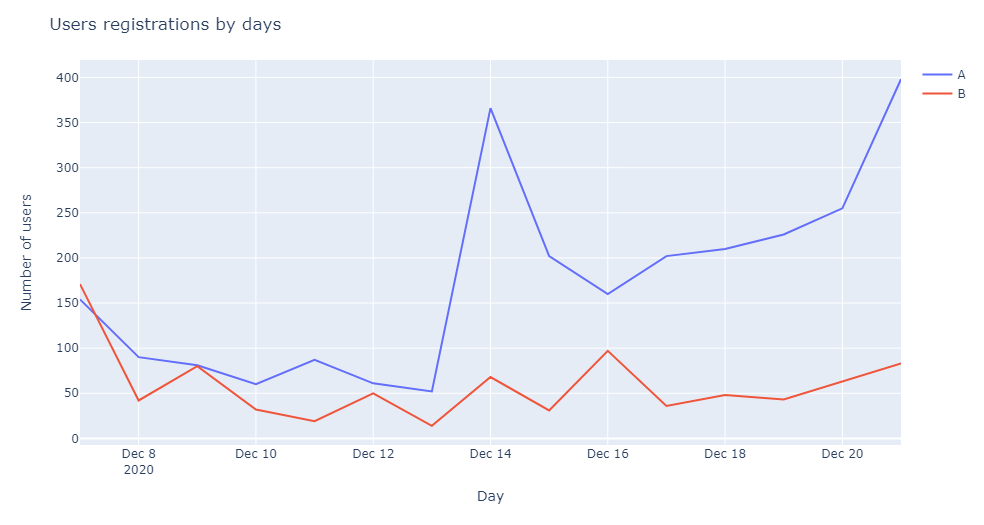

* New users in group A started to register more often starting from Dec 14

Now check active users by days

<div class="alert alert-block alert-warning">📝 <b> To do </b>

Change graph to seaborn of matplotlib. update labels and titles
</div>

In [87]:
fig = px.line(pd.pivot_table(df, 
                             index='group', 
                             columns='date', 
                             values='user_id', 
                             aggfunc='nunique').T)

fig.update_layout(title='Active users by days',
                  xaxis_title='Day',
                  yaxis_title='Number of users',
                  legend_title=None)

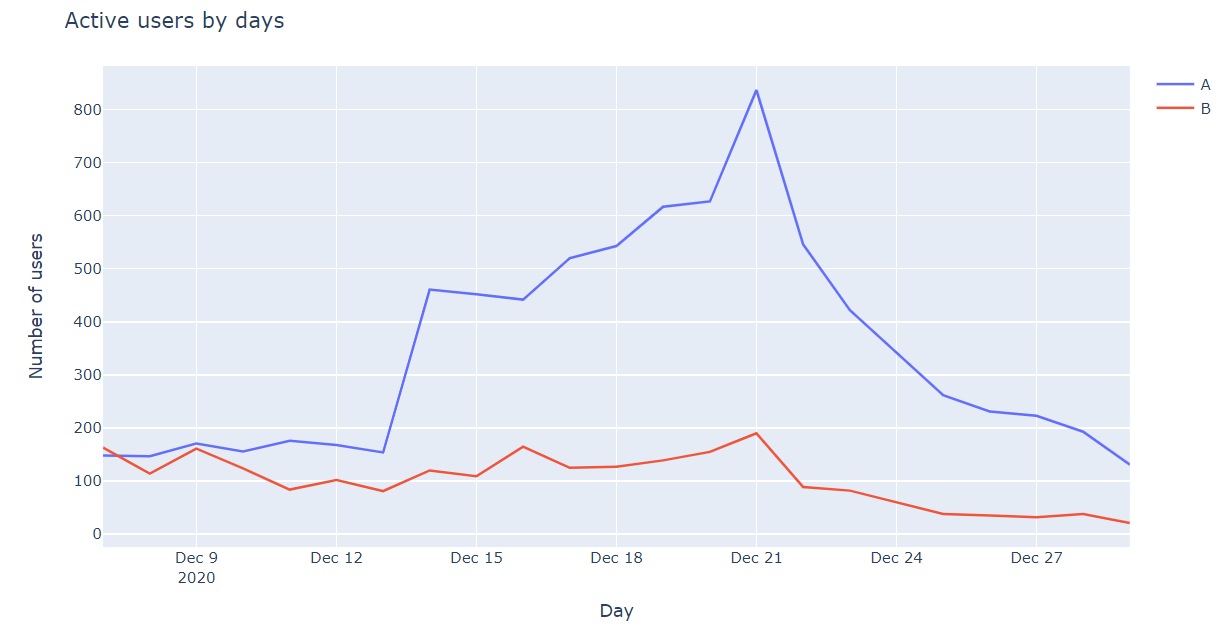

In [88]:
fig = px.line(pd.pivot_table(df, 
                             index='group', 
                             columns='weekday', 
                             values='user_id', 
                             aggfunc='nunique').T)

fig.update_layout(title='Active users by weekday',
                  xaxis_title='Week Day (0 = Monday)',
                  yaxis_title='Number of users',
                  legend_title=None)

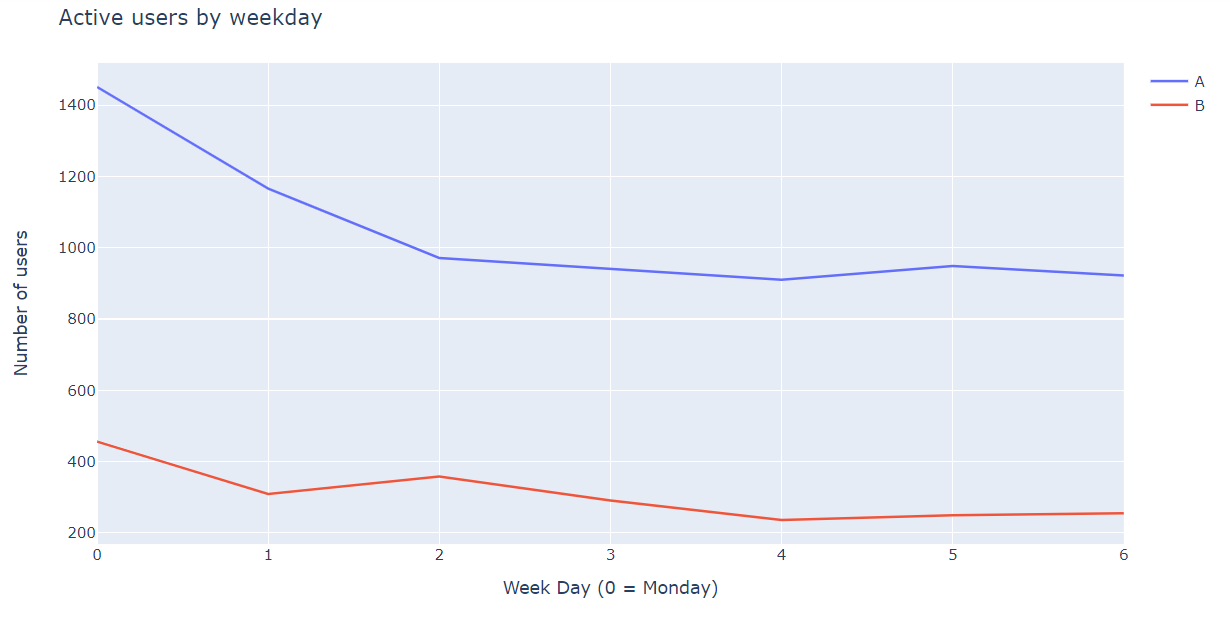

* Group A shows registrations boost staring from Dec 14 vs group B
* By weekdays group A activity is constantly higher than in B 
* In both groups Monday is the most active weekday
* Despite Xmas + New Year promo start at 25th Dec we do not indicate any significant changes in users' activity

In [89]:
fig = px.line(pd.pivot_table(df, 
                             index='group', 
                             columns='days', 
                             values='user_id', 
                             aggfunc='nunique').T)

fig.update_layout(title='Users activity by day after registration',
                  xaxis_title='# Day after registration',
                  yaxis_title='Number of users',
                  legend_title=None)

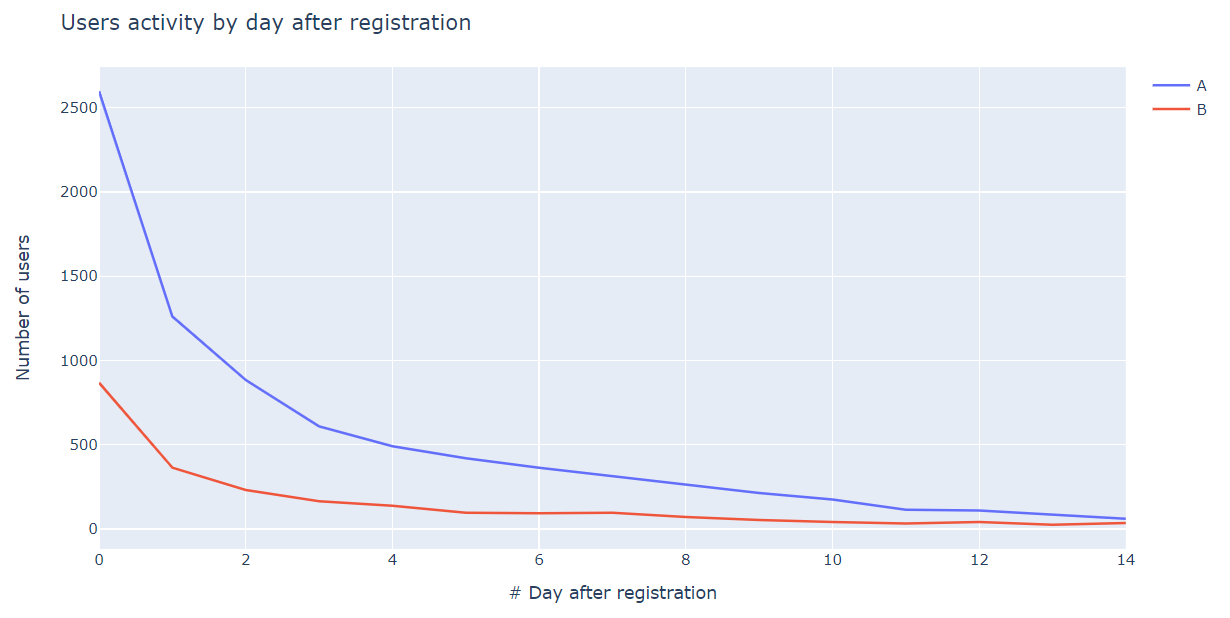

* Users usually the most active during the first several days after registration. After that the activity decreases

#### Average number of events

Building the histogram

Grouping data by A/B groups and user, after that calculating *count* of events per user

In [90]:
fig = px.histogram(df.groupby(['group', 'user_id']).agg({'event_name': 'count'}).reset_index(),
                   x='event_name',
                   color='group',
                   barmode='group')

fig.update_layout(title='Average amount of events per user in group',
                  xaxis_title='# of events',
                  yaxis_title='Number of users',
                  legend_title=None)

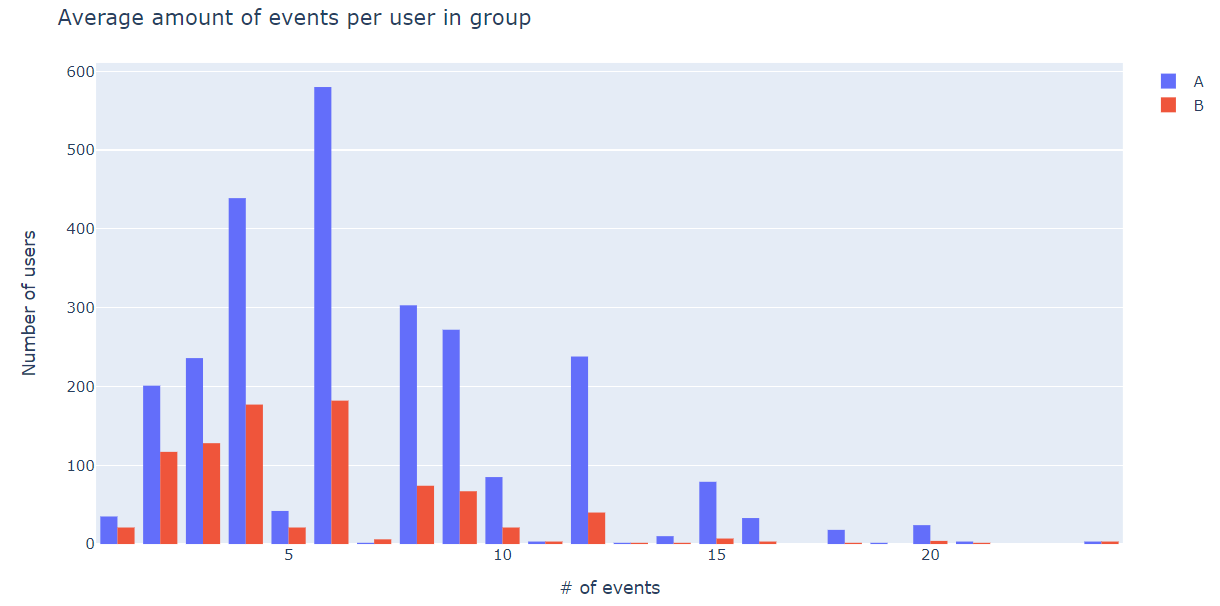

* In both groups the most frequent number of events is 4 and 6

#### By devices

Let's group unique users by devices in pivot table

In [78]:
devices = pd.pivot_table(df, index='device', columns='group', values='user_id', aggfunc='nunique')
devices

group,A,B
device,,
Android,1139,405
Mac,255,74
PC,689,212
iPhone,521,186


Now building two pies with shares per each device in group

In [91]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])


fig.add_trace(go.Pie(labels=devices.index, 
                     values=devices.iloc[:, 0],
                     name='A group'),
              1, 1)


fig.add_trace(go.Pie(labels=devices.index, 
                     values=devices.iloc[:, 1],
                     name='B group'),
              1, 2)

# Here we make white dots in the center of pies
fig.update_traces(hole=.3, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="User distribution by Devices",
    # here we add name of groups in white dots
    annotations=[dict(text='A', x=0.21, y=0.5, font_size=20, showarrow=False),
                 dict(text='B', x=0.79, y=0.5, font_size=20, showarrow=False)])
fig.show()

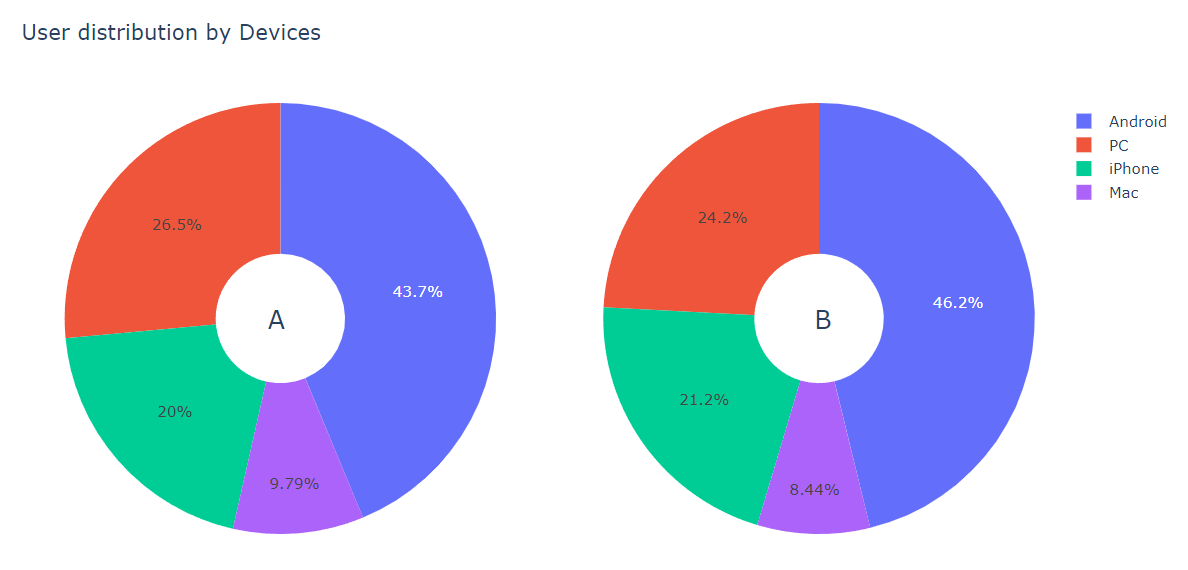

Distribution between two group is very similar:
* Major share is `Android`
* 2nd place `PC`
* 3rd and 4th for `iPhone` and `Mac`
* Users from group A prefer `PC` and `Mac` slightly more than `Android` and `iPhone` (comparing to group B)

### Funnel

#### Tables

Let's identify events sequence for proper funnel build

In [80]:
df.groupby('event_name').agg({'user_id': 'nunique'})

,user_id
event_name,
login,3480
product_cart,1026
product_page,2178
purchase,1082


Funnel logic should be the following:
1. login
2. product_page
3. product_cart
4. purchase

But in step 4 `purchase` the amount is bigger than in step 3 `product_cart` 

This might be explained by having the *quick purchase* option which avoid `product_cart` step

So, don't be scared of having step CR being >100%

In [81]:
# pivot_table by events in groups for funnel build
funnel_data = (pd.pivot_table(df,
                              index='event_name', 
                              columns='group', 
                              values='user_id', 
                              aggfunc='nunique').reindex(['login', 'product_page', 'product_cart', 'purchase'])
                )

User funnel:

In [82]:
funnel_data

group,A,B
event_name,,
login,2604,876
product_page,1685,493
product_cart,782,244
purchase,833,249


CR to the previous step, %

In [83]:
(funnel_data / funnel_data.shift()).fillna(1) * 100

group,A,B
event_name,,
login,100.000000,100.000000
product_page,64.708141,56.278539
product_cart,46.409496,49.492901
purchase,106.521739,102.049180


* Group B shows the bigger drop in `product_page` than A

CR to the first step (`login`), %

In [84]:
(funnel_data / funnel_data.iloc[0]).fillna(1) * 100

group,A,B
event_name,,
login,100.000000,100.000000
product_page,64.708141,56.278539
product_cart,30.030722,27.853881
purchase,31.989247,28.424658


* Conversion in group B vs A is lower among all 3 steps
* CR to `purchase` in group A = 32%, group B = 28.4%
* Now we can state that there is now `10% metric enhance` at each step as it was expected (despite the product_cart step, but it is not necessary one)

#### Chart

Visulaziation!

<div class="alert alert-block alert-warning">📝 <b> To do </b>

Change graph to seaborn of matplotlib. update labels and titles
</div>

In [93]:
for group in funnel_data.columns:
    fig = go.Figure(go.Funnel(
        y = funnel_data.index,
        x = funnel_data[group]))
    
    fig.update_layout(title='Funnel of group {}'.format(group))
    fig.show()

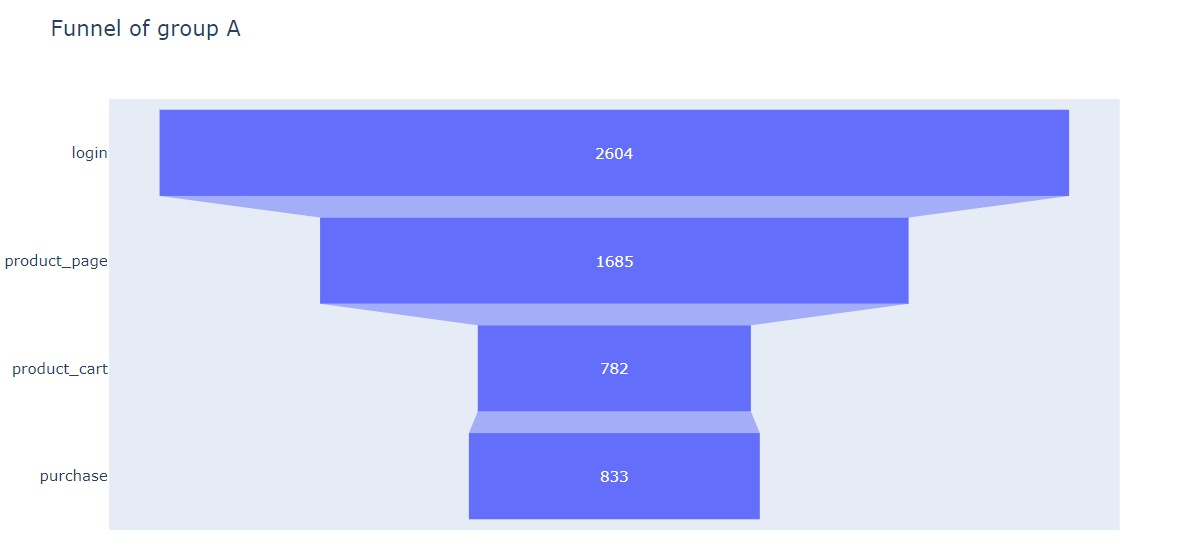

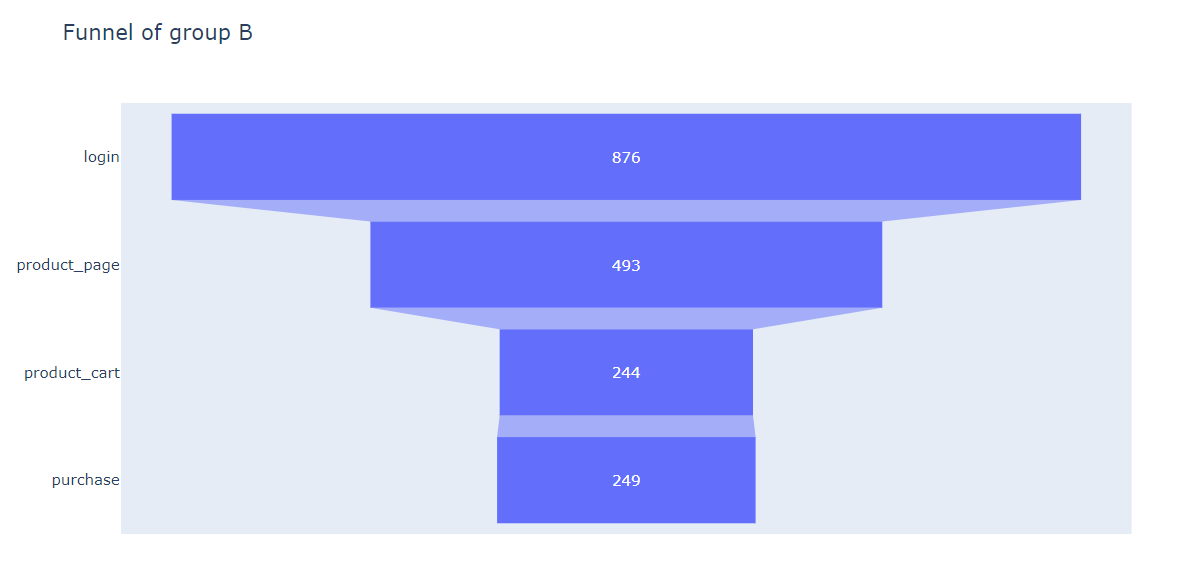

### Conclusion

* New users in group A are registering more often that in B, especially after Dec 14
* The most frequent number of events per user is 4 and 6
* Distribution by devices is almost the same:
    * 44-46% for Android
    * 24-26% for PC
    * 20-21% for iPhone
    * 8-10% for Mac
* Users Funnel doesn't look like "funnel" as the amount of purchases > product cart views (probably, product cart step is not necessary)
* By all steps group A conversion is better than group B (so 10% metric increase did not happen)
* CR to purhase by groups: A = 32%, B = 28.4%

## A/B testing

### Using Z-test

Let's check the following **hypothesis** using z-test:

* H_0: CR in group A = CR in group B
* H_a: CR in group A ≠ CR in group B
* alpha = 0.05

We check that hypothesis for each Conversion step: `product_page`, `product_cart`, `purchase`

Let's define function for z-test:

In [ ]:
"""
`successes` - [number of unique users who made an `action` in group A, 
number of unique users who made an `action` in group B]

`trials`- [total number of unique users in group A,
total number of unique users in group A]
"""

def z_test(successes1, successes2, trials1, trials2, alpha=0.05):
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    
    print(successes1, successes2, trials1, trials2)

    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-value: ', p_value)

    if (p_value < alpha):
        display('We decline zero-hypothesis, there is a statistical diffirence between groups')
    else:
        display('We cannot decline zero-hypothesis, so there is NO a statistical diffirence between groups')

In our case `trials` - is always logins for each group, `successes` - number of users on the following steps

Let's use **for** to walk through each step. Data is taken from var `funnel_data`

In [ ]:
funnel_data

Go thorugh the cycle to check each step of the funnel and make z-test

As we have **3 comparings** amoung the funnel stages, we need to make Bonferroni-adjustment of **alpha** = `alpha /3`

In [ ]:
for step in funnel_data.index[1:]:
    trials1 = funnel_data.loc['login', 'A']
    trials2 = funnel_data.loc['login', 'B']
    successes1 = funnel_data.loc[step, 'A']
    successes2 = funnel_data.loc[step, 'B']
    print('Check of step:', step)
    z_test(successes1, successes2, trials1, trials2, alpha=0.05 / len(funnel_data.index[1:]))

### Conclusion

* We declined zero-hypothesis that CR to `product_page` between two groups is identical. But we couldn't decline the same for steps `product_cart` and `purchase`
* As group B shows results worse than A, we can state that new recommendation system didn't fly well (might be even negative impact)
* Calcelling or repairing of this recommendation system is needed

## Final conclusion

### Data preprocessing

* In preprocessing read all the files and checked match to the techical task 
* Files are without mistakes and duplicates. Updated formats for dates
* Merged data under single variable `df` and checked to techical task match
* Dustribution between groups A and B is uneven 75 / 25%, but that's okay since the group amount is enough
* ❗Data related concern:
    * test ended by 4 Jan but the last event date was at 30th Dec. Where is rest 5 days data? (transfer this concern to **data collection team**)

### Exploratory analysis

* New users in group A are registering more often that in B, especially after Dec 14
* The most frequent number of events per user is 4 and 6
* Distribution by devices is almost the same:
    * 44-46% for Android
    * 24-26% for PC
    * 20-21% for iPhone
    * 8-10% for Mac
* Users Funnel doesn't look like "funnel" as the amount of purchases > product cart views (probably, product cart step is not necessary). **Double-check with Marketing team**
* **By all steps group A conversion is better than group B** (so 10% metric increase did not happen)
* CR to purhase by groups: A = 32%, B = 28.4%

### A/B test results

* We declined zero-hypothesis that CR to `product_page` between two groups is identical. But we couldn't decline the same for steps `product_cart` and `purchase`
* As group B shows results worse than A, we can state that new recommendation system didn't fly well (might be even negative impact)
* Calcelling or repairing of this recommendation system is needed